<a href="https://colab.research.google.com/github/ayush8587/Kaggle_Competition/blob/main/NLP_Disaster_Tweet_or_not.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Performing NLP on Tweets and classify whether it is related to disaster or not.**

### Downloading the dataset from Kaggle.

In [1]:
!pip install kaggle

In [7]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"singhayush16","key":"546a02a4a3490a835546d9dd9fa1e5cb"}'}

In [9]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [10]:
!kaggle datasets download -d vstepanenko/disaster-tweets

100% 656k/656k [00:00<00:00, 1.46MB/s]
100% 656k/656k [00:00<00:00, 1.46MB/s]


In [11]:
!unzip disaster-tweets.zip

Archive:  disaster-tweets.zip
  inflating: tweets.csv              


### *Importing Necessary Libraries*

In [12]:
!pip install emoji urlextract

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from wordcloud import WordCloud, STOPWORDS
import datetime
import emoji
from urlextract import URLExtract
import warnings
import string

%matplotlib inline
warnings.filterwarnings('ignore')

### Preprocessing and Reading Data

In [15]:
data=pd.read_csv('/content/tweets.csv')

In [16]:
data.sample(5)

,id,keyword,location,text,target
5554,5554,fear,London and Poole,Margaret Macmillan cites spiteful Wall St bank...,0
222,222,ambulance,Malibu,Just got back from the hospital bc I accidenta...,0
8621,8621,rescuers,"Michigan, USA",Wahoo! Australia rescuers dropping carrots in ...,1
641,641,attacked,NaN,Video from #Iran Exact date &amp; location unc...,0
7283,7283,mass%20murder,"Mangalore, India","""BJP leader threatens mass murder"" There, fixe...",0


In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11370 entries, 0 to 11369
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        11370 non-null  int64 
 1   keyword   11370 non-null  object
 2   location  7952 non-null   object
 3   text      11370 non-null  object
 4   target    11370 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 444.3+ KB


Location contains Null values. So, we have to process accordingly.

In [18]:
data.duplicated().sum()

0

In [19]:
data.nunique()

id          11370
keyword       219
location     4504
text        11223
target          2
dtype: int64

In [20]:
data.target.value_counts()

0    9256
1    2114
Name: target, dtype: int64

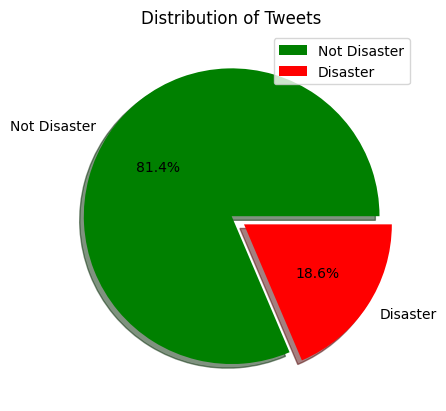

In [21]:
x=(data.target.value_counts().values[0]/len(data))*100
y=(data.target.value_counts().values[1]/len(data))*100
plt.pie([x,y],labels=['Not Disaster','Disaster'],colors=['g','r'],autopct='%1.1f%%',shadow=True,explode=[0,0.1])
plt.title("Distribution of Tweets")
plt.legend()
plt.show()

It is clearly visible that our dataset is unbalance i.e., more number of tweets which is not a Disaster than Disaster ones.

## 1. Performing Prediction without any preprocessing.

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

In [23]:
X=data['text']
y=data['target']
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=101)

In [24]:
X_train.shape,X_test.shape

((7959,), (3411,))

### Using Bag of Words and Random Forest Classifier

In [25]:
cv=CountVectorizer(max_features=3000)
X_train_bow=cv.fit_transform(X_train).toarray()
X_test_bow=cv.transform(X_test).toarray()

In [26]:
X_train_bow.shape

(7959, 3000)

In [27]:
rfc=RandomForestClassifier()
rfc.fit(X_train_bow,y_train)
pred=rfc.predict(X_test_bow)

In [28]:
rfc_accuracy_score=accuracy_score(y_test,pred)
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.89      0.99      0.94      2790
           1       0.88      0.46      0.60       621

    accuracy                           0.89      3411
   macro avg       0.89      0.72      0.77      3411
weighted avg       0.89      0.89      0.88      3411



### Using Bag of Words and XGB Classifier

In [29]:
xgb=XGBClassifier()
xgb.fit(X_train_bow,y_train)
pred=xgb.predict(X_test_bow)
xgb_accuracy_score=accuracy_score(y_test,pred)
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.89      0.98      0.93      2790
           1       0.82      0.45      0.58       621

    accuracy                           0.88      3411
   macro avg       0.85      0.71      0.76      3411
weighted avg       0.88      0.88      0.87      3411



We have got an overall **89%** accuracy without any preprocessing. But, very less Precision and Recall for Disaster Tweets. *(Due to imbalanced Dataset)*

## 2. Performing Oversampling to handle the imbalanced Dataset.

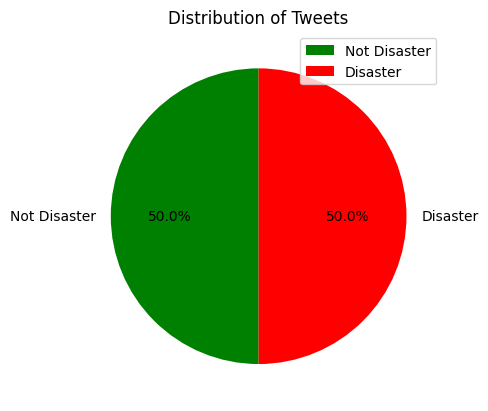

In [30]:
from sklearn.utils import resample

# concatenate our training data back together
df = pd.concat([X_train, y_train], axis=1)

# Separate majority and minority classes
df_majority = df[df.target==0]
df_minority = df[df.target==1]

# Upsample minority class
df_minority_upsampled = resample(df_minority,replace=True,n_samples=len(df_majority),random_state=101)

# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])

#Visualizing the balanced Dataset
x=(df_upsampled.target.value_counts().values[0]/len(data))*100
y=(df_upsampled.target.value_counts().values[1]/len(data))*100
plt.pie([x,y],labels=['Not Disaster','Disaster'],colors=['g','r'],autopct='%1.1f%%',startangle=90)
plt.title("Distribution of Tweets")
plt.legend()
plt.show()

### Using Bag of Words and Random Forest Classifier

In [31]:
cv=CountVectorizer(max_features=3000)
X_train_bow=cv.fit_transform(df_upsampled['text']).toarray()
y_train=df_upsampled['target']
X_test_bow=cv.transform(X_test).toarray()

In [32]:
rfc=RandomForestClassifier()
rfc.fit(X_train_bow,y_train)
pred=rfc.predict(X_test_bow)
rfc_accuracy_score=accuracy_score(y_test,pred)
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.90      0.98      0.94      2790
           1       0.83      0.53      0.64       621

    accuracy                           0.89      3411
   macro avg       0.87      0.75      0.79      3411
weighted avg       0.89      0.89      0.88      3411



### Using Bag of Words and XGBClassifier

In [33]:
xgb=XGBClassifier()
xgb.fit(X_train_bow,y_train)
pred=xgb.predict(X_test_bow)
xgb_accuracy_score=accuracy_score(y_test,pred)
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.93      0.89      0.91      2790
           1       0.59      0.70      0.64       621

    accuracy                           0.86      3411
   macro avg       0.76      0.80      0.77      3411
weighted avg       0.87      0.86      0.86      3411



Here, Recall and Precision is the metrics to look out for and XGBClassifier has overall best performance than other.

## 3. Text Preprocessing

In [34]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [35]:
def preprocess(text):
  text=text.lower()
  url=URLExtract()
  urls=url.find_urls(text)
  new_txt=[]
  for word in text.split():
      if word not in urls:
        new_txt.append(word)
  x=new_txt[:]
  new_txt.clear()
  text=re.sub(r'(?:@[\w_]+)|(?:\B#\w+)', ''," ".join(x))
  text=text.translate(str.maketrans('', '', string.punctuation))
  text=" ".join([word for word in str(text).split() if word not in set(stopwords.words('english'))])
  text=" ".join([lemmatizer.lemmatize(word) for word in text.split()])
  emoji_pattern = re.compile("["
          u"\U0001F600-\U0001F64F"  # emoticons
          u"\U0001F300-\U0001F5FF"  # symbols & pictographs
          u"\U0001F680-\U0001F6FF"  # transport & map symbols
          u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                            "]+", flags=re.UNICODE)
  return emoji_pattern.sub(r'', text)

In [36]:
data['preprocessed_text']=data['text'].apply(preprocess) #Text Preprocessing

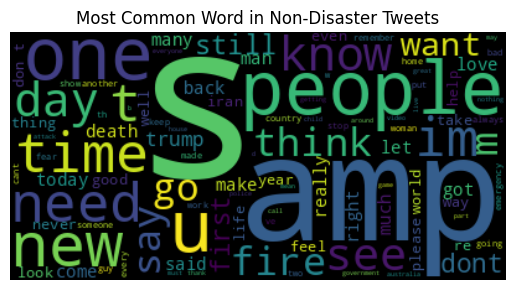

In [37]:
wordcloud = WordCloud(max_words=100, background_color="black").generate(" ".join(tweet for tweet in data[data['target']==0]["preprocessed_text"]))
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.title("Most Common Word in Non-Disaster Tweets")
plt.axis("off")
plt.show()

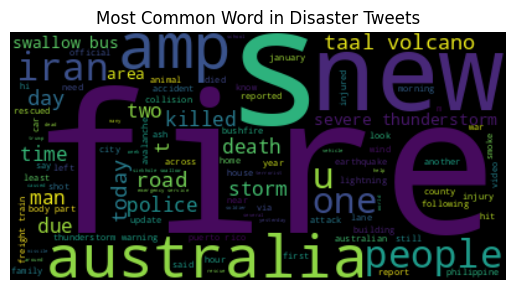

In [38]:
wordcloud = WordCloud(max_words=100, background_color="black").generate(" ".join(tweet for tweet in data[data['target']==1]["preprocessed_text"]))
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.title("Most Common Word in Disaster Tweets")
plt.axis("off")
plt.show()

In [39]:
X=data['preprocessed_text']
y=data['target']
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=101)

In [40]:
#oversampling of data to balanced the dataset
df = pd.concat([X_train, y_train], axis=1)
df_majority = df[df.target==0]
df_minority = df[df.target==1]
df_minority_upsampled = resample(df_minority,replace=True,n_samples=len(df_majority),random_state=101)
df_upsampled = pd.concat([df_majority, df_minority_upsampled])

In [41]:
tf=TfidfVectorizer(max_features=3000)
X_train_bow=tf.fit_transform(df_upsampled['preprocessed_text']).toarray()
y_train=df_upsampled['target']
X_test_bow=tf.transform(X_test).toarray()

In [42]:
X_train_bow.shape

(12932, 3000)

In [43]:
xgb=XGBClassifier()
xgb.fit(X_train_bow,y_train)
pred=xgb.predict(X_test_bow)
xgb_accuracy_score=accuracy_score(y_test,pred)
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.92      0.91      0.91      2790
           1       0.60      0.63      0.62       621

    accuracy                           0.86      3411
   macro avg       0.76      0.77      0.76      3411
weighted avg       0.86      0.86      0.86      3411



# Submission Part

In [45]:
test=pd.read_csv('/content/test.csv') #Reading the Test file

In [46]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


In [48]:
test.sample()

,id,keyword,location,text
1074,3551,derailment,India,Madhya Pradesh Train Derailment: Village Youth...


In [49]:
test['preprocessed_text']=test['text'].apply(preprocess) #Text Preprocessing

In [50]:
vectorized_text=tf.transform(test['preprocessed_text']).toarray()
test['target']=xgb.predict(vectorized_text)
test[['id','target']].to_csv('Submission.csv',index=False)